1) Setup & imports

In [14]:
# 02_Model_Training.ipynb — Forecasting for FUTURE_ML_01

import os, warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Try Prophet (preferred)
try:
    from prophet import Prophet
    HAS_PROPHET = True
except Exception:
    HAS_PROPHET = False

# Try SARIMAX (fallback)
try:
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    HAS_SARIMAX = True
except Exception:
    HAS_SARIMAX = False

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)

print("Prophet available:", HAS_PROPHET)
print("SARIMAX available:", HAS_SARIMAX)


Prophet available: True
SARIMAX available: True


2) Load cleaned data

In [15]:
# robust path detection
candidates = ["../data/cleaned_sales.csv", "data/cleaned_sales.csv", "./cleaned_sales.csv"]
cleaned_path = next((p for p in candidates if os.path.exists(p)), None)
if cleaned_path is None:
    raise FileNotFoundError("cleaned_sales.csv not found. Run 01_EDA.ipynb first to create it.")

df = pd.read_csv(cleaned_path)
if "Date" not in df.columns or "Sales" not in df.columns:
    raise ValueError("cleaned_sales.csv must have columns: Date, Sales")

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["Sales"] = pd.to_numeric(df["Sales"], errors="coerce")
df = df.dropna(subset=["Date", "Sales"]).sort_values("Date").reset_index(drop=True)

print("✅ Loaded:", cleaned_path, "| Shape:", df.shape, "| Date range:", df["Date"].min().date(), "→", df["Date"].max().date())
df.head()


✅ Loaded: ../data/cleaned_sales.csv | Shape: (1237, 2) | Date range: 2014-01-03 → 2017-12-30


,Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,4407.100
4,2014-01-07,87.158


3) Ensure daily continuity (fill missing days)

In [16]:
full_idx = pd.date_range(df["Date"].min(), df["Date"].max(), freq="D")
df_full = (
    df.set_index("Date")
      .reindex(full_idx)
      .rename_axis("Date")
      .reset_index()
)
df_full["Sales"] = df_full["Sales"].fillna(0.0)

print("📅 Days original:", len(df), "| after reindex:", len(df_full))
df_full.head()


📅 Days original: 1237 | after reindex: 1458


,Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,4407.100
4,2014-01-07,87.158


4) Train/validation split (time-based)

In [17]:
# Forecast horizon (days used for validation and for future prediction)
HORIZON = 90  # adjust if needed

if len(df_full) <= HORIZON + 30:
    raise ValueError(f"Not enough history ({len(df_full)} rows). Reduce HORIZON={HORIZON} or add more data.")

train = df_full.iloc[:-HORIZON].copy()
valid = df_full.iloc[-HORIZON:].copy()

print("Train:", train["Date"].min().date(), "→", train["Date"].max().date(), "| rows:", len(train))
print("Valid:", valid["Date"].min().date(), "→", valid["Date"].max().date(), "| rows:", len(valid))


Train: 2014-01-03 → 2017-10-01 | rows: 1368
Valid: 2017-10-02 → 2017-12-30 | rows: 90


5) Helper: metrics

In [18]:
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def mae(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.mean(np.abs(y_true - y_pred)))

def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return float(np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100)


6) Prophet model (if available)

In [19]:
results = {}
forecast_df = None

if HAS_PROPHET:
    print("🚀 Using Prophet")

    df_p = train.rename(columns={"Date":"ds", "Sales":"y"})
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode="additive",
        changepoint_prior_scale=0.5
    )
    m.fit(df_p)

    # Future = full history + validation horizon
    future = m.make_future_dataframe(periods=HORIZON, freq="D", include_history=True)
    fcst = m.predict(future)  # has columns ds, yhat, yhat_lower, yhat_upper

    # Exact alignment to validation dates (no KeyError, no NaN)
    fidx = fcst.set_index("ds")
    fcst_valid = fidx.reindex(valid["Date"]).reset_index()
    fcst_valid = fcst_valid.rename(columns={"index":"Date", "yhat":"Forecast", "yhat_lower":"Lower", "yhat_upper":"Upper"})

    merged = valid.merge(fcst_valid[["Date","Forecast","Lower","Upper"]], on="Date", how="left").dropna(subset=["Forecast"])

    results["RMSE"] = rmse(merged["Sales"], merged["Forecast"])
    results["MAE"]  = mae(merged["Sales"], merged["Forecast"])
    results["MAPE"] = mape(merged["Sales"], merged["Forecast"])

    # For dashboard: keep history + future
    forecast_df = fcst.rename(columns={"ds":"Date","yhat":"Forecast","yhat_lower":"Lower","yhat_upper":"Upper"})[
        ["Date","Forecast","Lower","Upper"]
    ]
    model_used = "Prophet"

elif HAS_SARIMAX:
    print("🚀 Using SARIMAX (statsmodels)")

    y_train = train.set_index("Date")["Sales"]
    y_valid = valid.set_index("Date")["Sales"]

    # Weekly seasonality for daily data
    model = SARIMAX(
        y_train,
        order=(1,1,1),
        seasonal_order=(1,1,1,7),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    # Validation predictions
    pred_valid = res.get_prediction(start=y_valid.index[0], end=y_valid.index[-1], dynamic=False)
    pred_mean = pred_valid.predicted_mean
    pred_ci = pred_valid.conf_int(alpha=0.2)  # ~80% band

    merged = pd.DataFrame({
        "Date": y_valid.index,
        "Sales": y_valid.values,
        "Forecast": pred_mean.values,
        "Lower": pred_ci.iloc[:,0].values,
        "Upper": pred_ci.iloc[:,1].values
    }).dropna(subset=["Forecast"])

    results["RMSE"] = rmse(merged["Sales"], merged["Forecast"])
    results["MAE"]  = mae(merged["Sales"], merged["Forecast"])
    results["MAPE"] = mape(merged["Sales"], merged["Forecast"])

    # Build full (history + future horizon)
    last_date = df_full["Date"].max()

    fitted = res.get_prediction(start=df_full["Date"].min(), end=last_date, dynamic=False)
    fitted_mean = fitted.predicted_mean
    fitted_ci = fitted.conf_int(alpha=0.2)

    steps = HORIZON
    future_fore = res.get_forecast(steps=steps)
    future_mean = future_fore.predicted_mean
    future_ci = future_fore.conf_int(alpha=0.2)

    hist_part = pd.DataFrame({
        "Date": fitted_mean.index,
        "Forecast": fitted_mean.values,
        "Lower": fitted_ci.iloc[:,0].values,
        "Upper": fitted_ci.iloc[:,1].values
    })

    fut_idx = pd.date_range(last_date + pd.Timedelta(days=1), periods=steps, freq="D")
    fut_part = pd.DataFrame({
        "Date": fut_idx,
        "Forecast": future_mean.values,
        "Lower": future_ci.iloc[:,0].values,
        "Upper": future_ci.iloc[:,1].values
    })

    forecast_df = pd.concat([hist_part, fut_part], ignore_index=True)
    model_used = "SARIMAX"

else:
    raise ImportError("Neither Prophet nor statsmodels (SARIMAX) is installed. Install at least one: `pip install prophet` or `pip install statsmodels`.")

print("✅ Model:", model_used, "| Metrics:", results)


🚀 Using Prophet


22:21:53 - cmdstanpy - INFO - Chain [1] start processing
22:22:02 - cmdstanpy - INFO - Chain [1] done processing


✅ Model: Prophet | Metrics: {'RMSE': 2870.265429638017, 'MAE': 2023.997680885526, 'MAPE': 543.0998519224681}


Cell 7 — Plot: Actual vs Forecast (recent window)

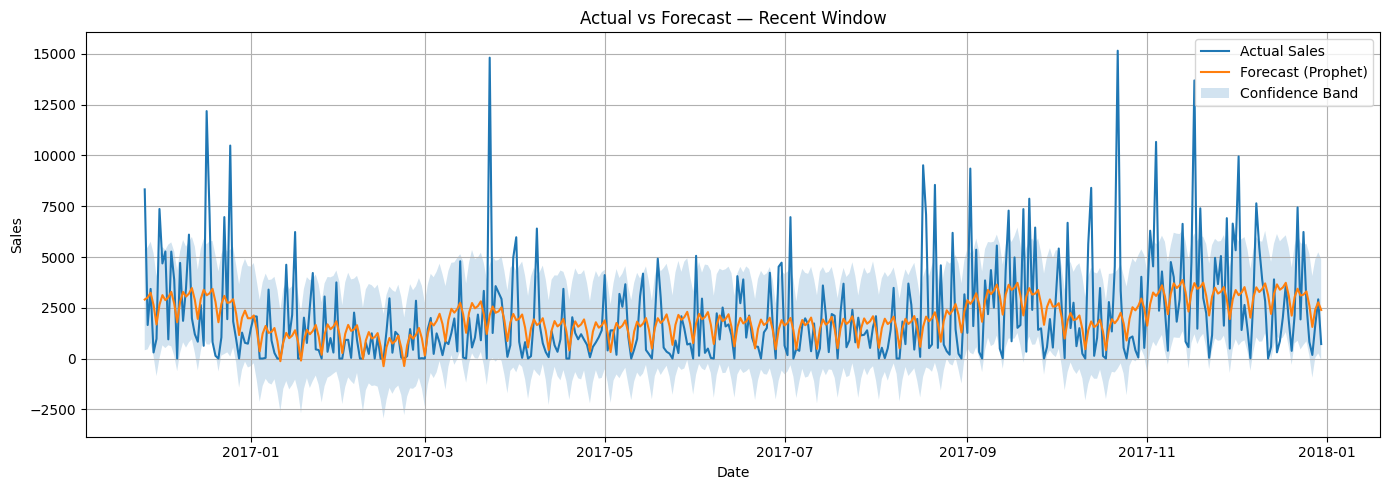

In [20]:
plt.figure(figsize=(14,5))

# recent window to keep plot readable
lookback = min(len(df_full), 400)
plot_actual = df_full.iloc[-lookback:].copy()

plt.plot(plot_actual["Date"], plot_actual["Sales"], label="Actual Sales")

# align forecast to same window
f_slice = forecast_df[forecast_df["Date"].between(plot_actual["Date"].min(), plot_actual["Date"].max())]
plt.plot(f_slice["Date"], f_slice["Forecast"], label=f"Forecast ({model_used})")

if {"Lower","Upper"}.issubset(f_slice.columns):
    # Some SARIMAX/Prophet bands can have NaNs at edges; fill for plotting
    lower = f_slice["Lower"].astype(float).fillna(method="bfill").fillna(method="ffill")
    upper = f_slice["Upper"].astype(float).fillna(method="bfill").fillna(method="ffill")
    plt.fill_between(f_slice["Date"], lower, upper, alpha=0.2, label="Confidence Band")

plt.title("Actual vs Forecast — Recent Window")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


Cell 8 — Save outputs for dashboard

In [21]:
# Decide data folder
data_dir = "../data" if os.path.isdir("../data") else "data"
os.makedirs(data_dir, exist_ok=True)

# 1) Forecast results (history + horizon)
forecast_out = os.path.join(data_dir, "forecast_results.csv")
forecast_df_out = forecast_df.rename(columns={"Date":"ds","Forecast":"yhat","Lower":"yhat_lower","Upper":"yhat_upper"})
forecast_df_out.to_csv(forecast_out, index=False)

# 2) Actual vs forecast combined (convenience for Power BI)
actual = df_full.rename(columns={"Date":"ds","Sales":"y"})[["ds","y"]]
combo = actual.merge(forecast_df_out, on="ds", how="left")
combo_out = os.path.join(data_dir, "actual_vs_forecast.csv")
combo.to_csv(combo_out, index=False)

print("💾 Saved:")
print(" -", forecast_out)
print(" -", combo_out)
combo.tail()


💾 Saved:
 - ../data\forecast_results.csv
 - ../data\actual_vs_forecast.csv


,ds,y,yhat,yhat_lower,yhat_upper
1453,2017-12-26,814.5940,2607.041100,139.442371,5154.764116
1454,2017-12-27,177.6360,1556.559609,-943.240151,4062.002165
1455,2017-12-28,1657.3508,2415.229999,32.690324,4879.036372
1456,2017-12-29,2915.5340,2768.979813,252.721751,5233.364835
1457,2017-12-30,713.7900,2391.469221,-63.842382,4896.015440


Cell 9 — Print clean metrics summary

In [22]:
print("📈 Evaluation on Validation Window")
for k, v in results.items():
    print(f"  {k}: {v:.3f}")
print("✅ Done.")


📈 Evaluation on Validation Window
  RMSE: 2870.265
  MAE: 2023.998
  MAPE: 543.100
✅ Done.


10) (Optional) Merge actual + forecast for direct comparison

In [ ]:
# Create a combined file (nice for Power BI toggles)
actual = df_full.rename(columns={"Date":"ds","Sales":"y"})[["ds","y"]]
combo = actual.merge(to_save, on="ds", how="left")

combo_out = "../data/actual_vs_forecast.csv" if os.path.isdir("../data") else "data/actual_vs_forecast.csv"
combo.to_csv(combo_out, index=False)
print("💾 Saved combined actual_vs_forecast →", combo_out)
combo.tail()
